# Basic hidden Markov models

In [1]:
import numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt
from scipy import stats

In [2]:
class MultinomialHMM:
    '''
    A discrete state HMM with multinomial emissions. Supports filtering, smoothing, and fitting via the Baum-Welch algorithm.
    '''
    def __init__(self, A, B, π):
        '''
        Initialize the model.
        Parameters:
            A: transition matrix
            B: observation matrix
            π: initial state distribution
        Returns: None
        '''
        self.A = A
        self.B = B
        self.π = π
        self.N = A.shape[0]
    
    def forward(self, O, scale=True):
        '''
        Runs the forward pass algorithm, used in filtering and smoothing.
        Parameters:
            O: a sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            α: array
            c: array, if scale is True
        '''
        T = len(O)
        α = np.zeros((self.N, T))
        if scale:
            c = np.zeros(T)
        for i in range(self.N):
            α[i, 0] = self.π[i] * self.B[i, O[0]]
        if scale:
            c[0] = 1 / np.sum(α[:, 0])
            α[:, 0] *= c[0]
        t = 1
        while t < T:
            for i in range(self.N):
                α[i, t] = np.sum(α[:, t-1] * self.A[:, i] * self.B[i, O[t]])
            if scale:
                c[t] = 1 / np.sum(α[:, t])
                α[:, t] *= c[t]
            t += 1
        if scale:
            return α, c
        else:
            return α
    
    def backward(self, O, c=None):
        '''
        Runs the backward pass algorithm, used in smoothing. Rescales at each step if an array of scaling parameters (from the forward pass) is passed.
        Parameters:
            O: a sequence of observations
            c: an array of scaling parameters
        Returns:
            β: backward pass parameters
        '''
        T = len(O)
        β = np.zeros((self.N, T))
        for i in range(self.N):
            β[i, T-1] = 1
            if c is not None:
                β[i, T-1] *= c[T-1]
        t = T-1
        while t > 0:
            for i in range(self.N):
                β[i, t-1] = np.sum(β[:, t] * self.A[i, :] * self.B[:, O[t]])
                if c is not None:
                    β[i, t-1] *= c[t-1]
            t -= 1
        return β
    
    def filter(self, O, scale = True):
        '''
        Returns the estimated distribution of states at time T, given observations O.
        Parameters:
            O: sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            Array of probabilities
        '''
        T = len(O)
        α, c = self.forward(O, scale)
        return α[:, T - 1] / np.sum(α[:, T - 1])
    
    def smooth(self, O, scale = True):
        '''
        Returns the estimated distribution of states at all times, given observations O.
        Parameters:
            O: sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            Array of probabilities
        '''
        T = len(O)
        if scale:
            α, c = self.forward(O, scale)
        else:
            α = self.forward(O, scale)
            c = None
        β = self.backward(O, c)
        if scale:
            return α * β / c
        else:
            norm = np.sum(α[:, T-1])
            return α * β / norm
    
    def generate(self, T):
        '''
        Generate simulated data given the current model parameters.
        Parameters:
            T: length of sequence to generate
        Returns:
            states: sequence of hidden states
            obs: sequence of observations
        '''
        states = np.zeros(T, dtype = np.int64)
        obs = np.zeros(T, dtype = np.int64)
        states[0] = np.random.choice(a=self.N, p=self.π)
        for t in range(1, T):
            states[t] = np.random.choice(a=self.N, p=self.A[states[t-1], :])
        for t in range(T):
            obs[t] = np.random.choice(a=self.B.shape[1], p=self.B[states[t], :])
        return states, obs
    
    def baum_welch_step(self, O):
        '''
        Performs a single step of the Baum-Welch EM algorithm for fitting HMM parameters.
        Parameters:
            O: sequence of observations
        Returns:
            newA: new transition matrix
            newB: new observation matrix
            newπ: new initial state distribution
            logP: log-probability of the observations under the new model
        '''
        T = len(O)
        α, c = self.forward(O)
        β = self.backward(O, c)
        
        ϝ = np.zeros((self.N, self.N, T-1))
        Y = np.zeros((T, self.B.shape[1]))
        γ = α * β / c
        
        newA = np.zeros_like(self.A)
        newB = np.zeros_like(self.B)
        newπ = np.zeros_like(self.π)
        
        for j in range(self.N):
            ϝ[:, j, :] = (self.A[:, j].reshape(self.N,1) * α[:, :T-1])
            ϝ[:, j, :] *= β[j,1:]
            ϝ[:, j, :] *= self.B[j, O[1:]]
            
        for i in range(self.N):
            for j in range(self.N):
                newA[i, j] = np.sum(ϝ[i, j, :T-1]) / np.sum(γ[i, :T-1])
        
        for i in range(self.N):
            for j in range(self.B.shape[1]):
                for t in range(T):
                    if O[t] == j:
                        newB[i, j] += γ[i, t]
                newB[i,j] /= np.sum(γ[i, :])
        newπ = γ[:,0]

        logP = -np.sum(np.log(c))
        return newA, newB, newπ, logP
        
    def bw_run(self, O, steps, tol = 1e-5, verbose = False):
        '''
        Runs the Baum-Welch EM algorithm to fit the HMM to an observed sequence.
        Parameters:
            O: sequence of observations
            steps: maximum number of iterations to run
            tol: tolerance; stop early if delta log-probability falls below this threshold
            verbose: if True, print the delta log-probability after each step
        Returns: None (modifies model parameters in-place)
        '''
        _, c = self.forward(O)
        oldlogP = -np.sum(np.log(c))
        print('Initial log-probability:', oldlogP)
        for i in range(steps):
            newA, newB, newπ, logP = self.baum_welch_step(O)
            if verbose:
                print('Step', i)
                print('Delta log-probability:', logP - oldlogP)
            if i > 0 and (logP - oldlogP < tol):
                print('Tolerance reached.')
                break
            self.A = newA
            self.B = newB
            self.π = newπ
            oldlogP = logP
        else:
            print('Maximum iterations reached.')
        print('Final log-probability:', logP)
    
    @staticmethod
    def init_matrix(n, m, scale = 0.15):
        '''
        Static method for initializing matrices for fitting.
        '''
        A = np.ones((n, m)) + scale * np.random.randn(n, m)
        for i in range(n):
            A[i,:] /= np.sum(A[i,:])
        return A

### The unfair casino problem


#### Filtering

In [3]:
diceA = np.array([[0.95, 0.05], [0.05, 0.95]])
diceB = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                  [1/2, 1/10, 1/10, 1/10, 1/10, 1/10]])
diceπ = np.array([1., 0.])
casino = MultinomialHMM(diceA, diceB, diceπ)
T_max = 300

In [4]:
state, obs = casino.generate(T_max)

In [5]:
filter_path = np.array([casino.filter(obs[:t]) for t in range(1, T_max)])[:,1]

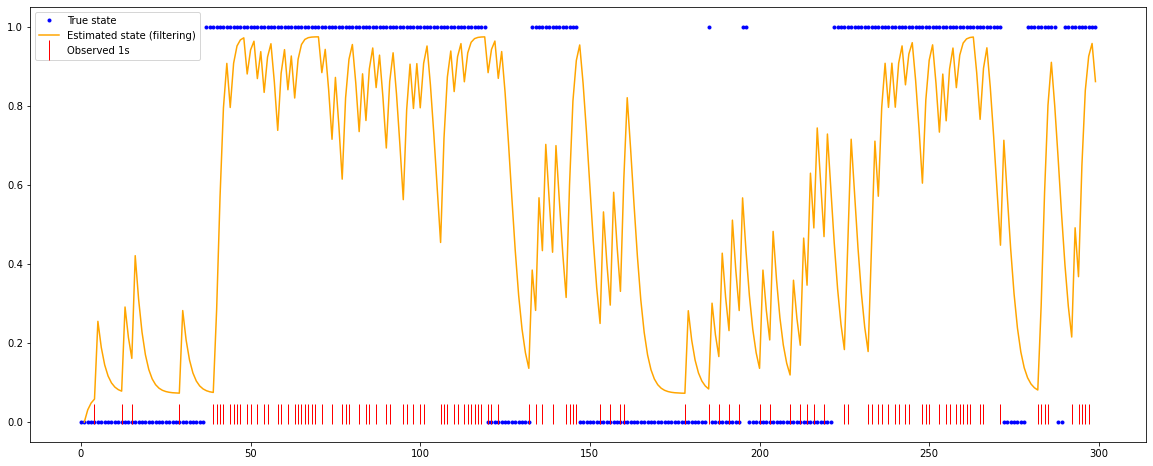

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(range(T_max), state, '.', color = 'blue', label = 'True state')
plt.plot(range(1, T_max), filter_path, label = 'Estimated state (filtering)', color = 'orange')
plt.plot([t for t in range(T_max) if obs[t] == 0], [0.02 for t in range(T_max) if obs[t] == 0], '|', markersize=20, color = 'red', label = 'Observed 1s')
plt.legend()
plt.show()

#### Smoothing

In [7]:
smooth_path = casino.smooth(obs)[1, :]

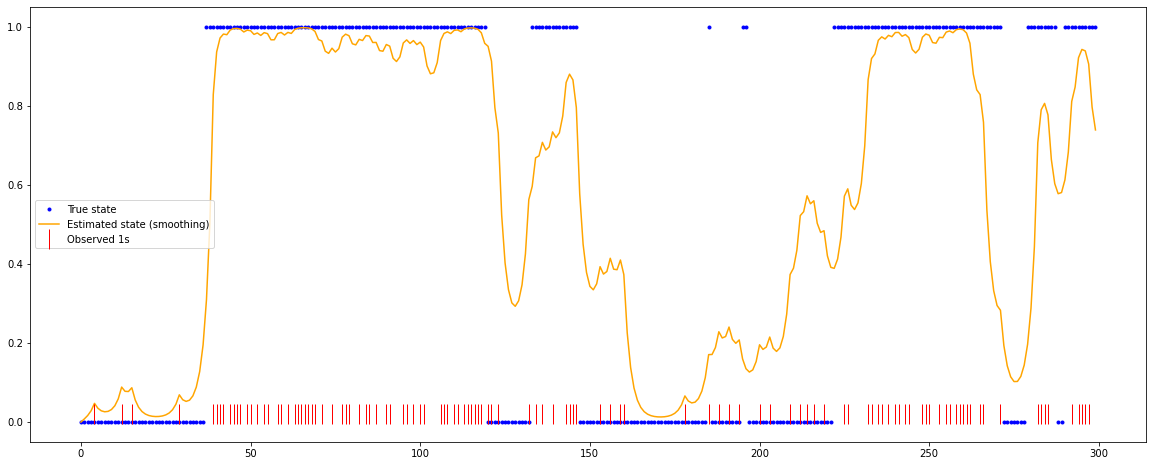

In [8]:
plt.figure(figsize=(20, 8))
plt.plot(range(T_max), state, '.', color = 'blue', label = 'True state')
plt.plot(range(T_max), smooth_path, label = 'Estimated state (smoothing)', color = 'orange')
plt.plot([t for t in range(T_max) if obs[t] == 0], [0.02 for t in range(T_max) if obs[t] == 0], '|', markersize=20, color = 'red', label = 'Observed 1s')
plt.legend()
plt.show()

#### Fitting

Here, we test the Baum-Welch algorithm for inferring model parameters, and see if it can recover the properties of the unfair casino model well enough to perform accurate filtering and smoothing on future data.

In [9]:
diceA = np.array([[0.95, 0.05], [0.05, 0.95]])
diceB = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
                  [1/2, 1/10, 1/10, 1/10, 1/10, 1/10]])
diceπ = np.array([1., 0.])
casino_true = MultinomialHMM(diceA, diceB, diceπ)
T_max = 1200

In [10]:
A = MultinomialHMM.init_matrix(2,2)
B = MultinomialHMM.init_matrix(2, 6)
π = MultinomialHMM.init_matrix(1,2).reshape(2)
casino_test = MultinomialHMM(A, B, π)

In [11]:
casino_test.B

array([[0.12637558, 0.13014439, 0.18066613, 0.22376209, 0.17579532,
        0.1632565 ],
       [0.15497989, 0.14829117, 0.16185797, 0.220222  , 0.14692764,
        0.16772133]])

In [12]:
casino_test.π

array([0.4948374, 0.5051626])

In [13]:
state, obs = casino_true.generate(T_max)

In [14]:
casino_test.bw_run(obs, 500, verbose = False)

Initial log-probability: -2193.6344017063093
Maximum iterations reached.
Final log-probability: -2049.9399844535997


In [15]:
np.round(casino_test.B, 3)

array([[0.36 , 0.   , 0.159, 0.224, 0.138, 0.119],
       [0.294, 0.276, 0.112, 0.068, 0.121, 0.128]])

In [16]:
np.round(casino_test.A, 3)

array([[0.373, 0.627],
       [0.723, 0.277]])

In [17]:
casino_test.π

array([1.00000000e+000, 2.48986769e-143])

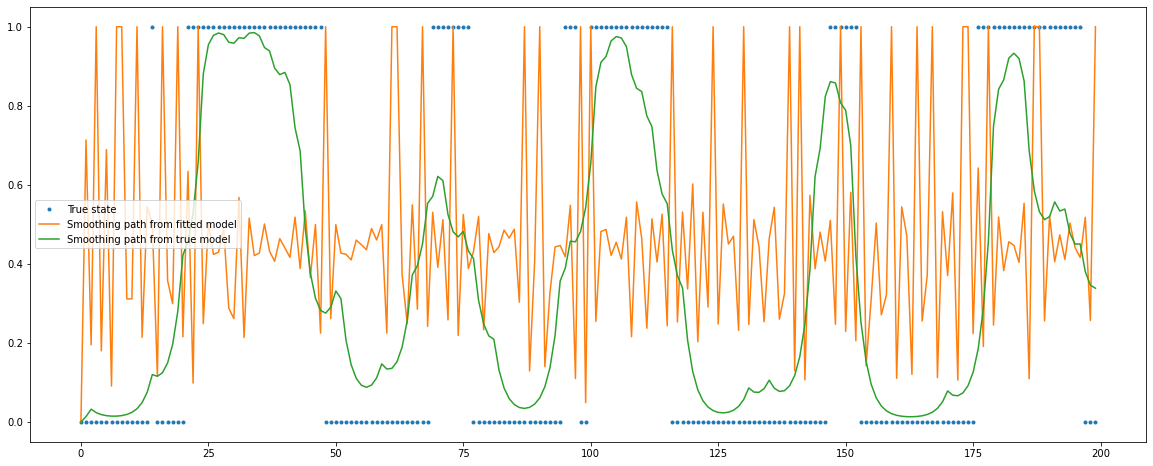

In [18]:
new_states, new_obs = casino_true.generate(200)
prediction = casino_test.smooth(new_obs)[1, :]
true_prediction = casino_true.smooth(new_obs)[1, :]
plt.figure(figsize=(20, 8))
plt.plot(range(200), new_states, '.', label = 'True state')
plt.plot(range(200), prediction, label = 'Smoothing path from fitted model')
plt.plot(range(200), true_prediction, label = 'Smoothing path from true model')
plt.legend()
plt.show()

## Using our HMM to analyze patterns in text

In [19]:
chars = ' abcdefghijklmnopqrstuvwxyz'
def sample_to_int(string):
    return np.array([chars.find(ch) for ch in string])

In [20]:
sample_to_int(chars)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [21]:
with open('dune_cleaned.txt') as fp:
    dune = fp.read()
    dune_raw = [ch for ch in dune.lower() if ch in chars]
    dune = sample_to_int(dune_raw)
len(dune)
max(dune)

26

In [22]:
''.join(dune_raw)[:500]

'dune frank herbert copyright  book  dune       a beginning is the time for taking the most delicate care that the balances are correct this every sister of the bene gesserit knows to begin your study of the life of muaddib then take care that you first place him in his time born in the th year of the padishah emperor shaddam iv and take the most special care that you locate muaddib in his place the planet arrakis do not be deceived by the fact that he was born on caladan and lived his first fift'

In [23]:
A = MultinomialHMM.init_matrix(2,2)
B = MultinomialHMM.init_matrix(2,27)
π = MultinomialHMM.init_matrix(1,2).reshape(2)
dune_model = MultinomialHMM(A, B, π)

In [24]:
dune_model.bw_run(dune[0:1500], 250, verbose = False)

Initial log-probability: -4930.92570239967
Maximum iterations reached.
Final log-probability: -4052.7672319287703


In [25]:
dune_model.A

array([[0.26608456, 0.73391544],
       [0.78487796, 0.21512204]])

In [26]:
pd.DataFrame(data={'letter':list(chars), 'state1':np.round(dune_model.B[0,:], 3), 'state2':np.round(dune_model.B[1,:], 3)})

,letter,state1,state2
0,,0.374,0.000
1,a,0.160,0.000
2,b,0.000,0.039
3,c,0.000,0.041
4,d,0.000,0.079
5,e,0.172,0.042
6,f,0.000,0.044
7,g,0.000,0.026
8,h,0.053,0.050
9,i,0.101,0.000


## Gaussian emissions

In [27]:
class GaussianHMM:
    '''
    A modification of the previous class for Gaussian emissions. Implements filtering and smoothing, but not yet fitting.
    '''
    def __init__(self, A, means, covs, π):
        '''
        Initialize the model.
        Parameters:
            A: transition matrix
            means: sequence of mean vectors for observations
            covs: sequence of covariance matrices for observations
            π: initial state distribution
        Returns: None
        '''
        self.A = A
        self.means = means
        self.covs = covs
        self.π = π
        self.N = len(π)
    
    def forward(self, O):
        '''
        Runs the forward pass algorithm, used in filtering and smoothing.
        Parameters:
            O: a sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            α: array
            c: array, if scale is True
        '''
        T = len(O)
        α = np.zeros((self.N, T))
        c = np.zeros(T)
        for i in range(self.N):
            α[i, 0] = self.π[i] * sp.stats.multivariate_normal(mean=means[i], cov=covs[i]).pdf(O[0])
        c[0] = 1 / np.sum(α[:,0])
        α[:, 0] *= c[0]
        t = 1
        while t < T:
            for i in range(self.N):
                α[i, t] = np.sum(α[:, t-1] * self.A[:, i] * sp.stats.multivariate_normal(mean=means[i], cov=covs[i]).pdf(O[t]))
            c[t] = 1 / np.sum(α[:,t])
            α[:, t] *= c[t]
            t += 1
        return α, c
    
    def backward(self, O, c):
        '''
        Runs the backward pass algorithm, used in smoothing. Rescales at each step if an array of scaling parameters (from the forward pass) is passed.
        Parameters:
            O: a sequence of observations
            c: an array of scaling parameters
        Returns:
            β: backward pass parameters
        '''
        T = len(O)
        β = np.zeros((self.N, T))
        for i in range(self.N):
            β[i, T-1] = 1
        β[:, T - 1] *= c[T-1]
        t = T-1
        while t > 0:
            for i in range(self.N):
                v = np.array([sp.stats.multivariate_normal(mean=self.means[j], cov=self.covs[j]).pdf(O[t]) for j in range(self.N)])
                β[i, t-1] = np.sum(β[:, t] * self.A[i, :] * v[:])
            β[:, t-1] *= c[t-1]
            t -= 1
        return β
    
    def filter(self, O):
        '''
        Returns the estimated distribution of states at time T, given observations O.
        Parameters:
            O: sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            Array of probabilities
        '''
        T = len(O)
        α = self.forward(O)
        return α[:, T - 1] / np.sum(α[:, T - 1])
    
    def smooth(self, O):
        '''
        Returns the estimated distribution of states at all times, given observations O.
        Parameters:
            O: sequence of observations
            scale: boolean, determines whether to rescale each step. Should be True (default) for longer sequences to avoid underflow.
        Returns:
            Array of probabilities
        '''
        T = len(O)
        α, c = self.forward(O)
        β = self.backward(O, c)
        norm = sum(α[:, T-1])
        return α * β / c
    
    def generate(self, T):
        '''
        Generate simulated data given the current model parameters.
        Parameters:
            T: length of sequence to generate
        Returns:
            states: sequence of hidden states
            obs: sequence of observations
        '''
        states = np.zeros(T, dtype = np.int64)
        obs = []
        states[0] = np.random.choice(a=self.N, p=self.π)
        for t in range(1, T):
            states[t] = np.random.choice(a=self.N, p=self.A[states[t-1]])
        for t in range(T):
            obs.append(sp.stats.multivariate_normal(mean=self.means[states[t]], cov=self.covs[states[t]]).rvs())
        return states, np.array(obs)


Below we test a 2-state HMM. The emission distributions are chosen to overlap a fair amount so that the Markov process plays a strong role in estimating which state produced a given observation.

In [28]:
# Set model parameters
A = np.array([[0.9, 0.1], [0.05, 0.95]])
means = [np.array([1.0, 2.0]), np.array([2.0, 1.0])]
covs = [np.eye(2), np.eye(2)]
π = np.array([0.5, 0.5])

In [29]:
# Generate data
gmodel = GaussianHMM(A, means, covs, π)
states, obs = gmodel.generate(500)

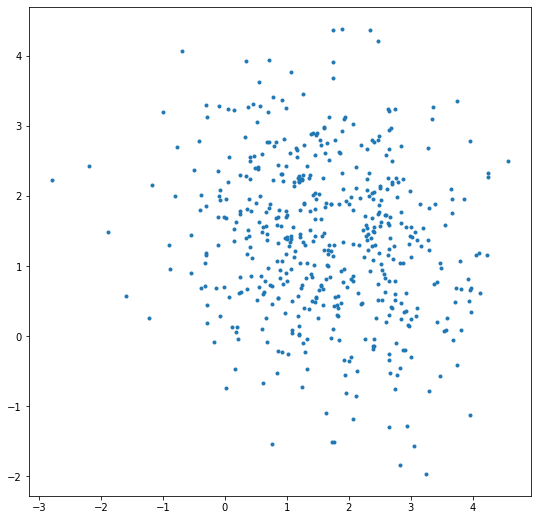

In [30]:
# What do the observed data look like?
plt.figure(figsize=(9, 9))
plt.plot(obs[:,0], obs[:,1], '.')
plt.show()

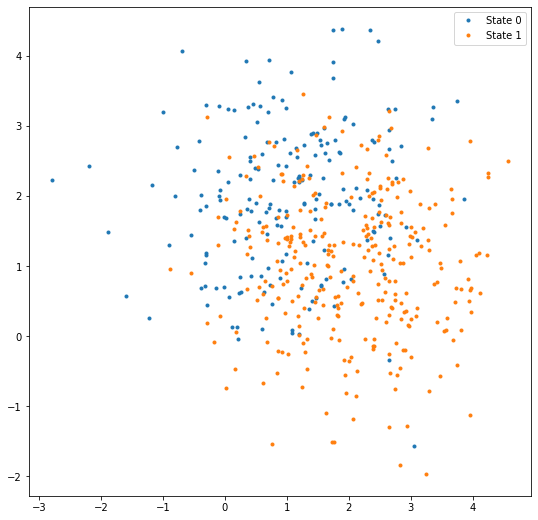

In [31]:
# What do the observed data look like?
plt.figure(figsize=(9, 9))
plt.plot(obs[states==0,0], obs[states==0,1], '.', label = 'State 0')
plt.plot(obs[states==1,0], obs[states==1,1], '.', label = 'State 1')
plt.legend()
plt.show()

In [32]:
smooth_path = gmodel.smooth(obs)

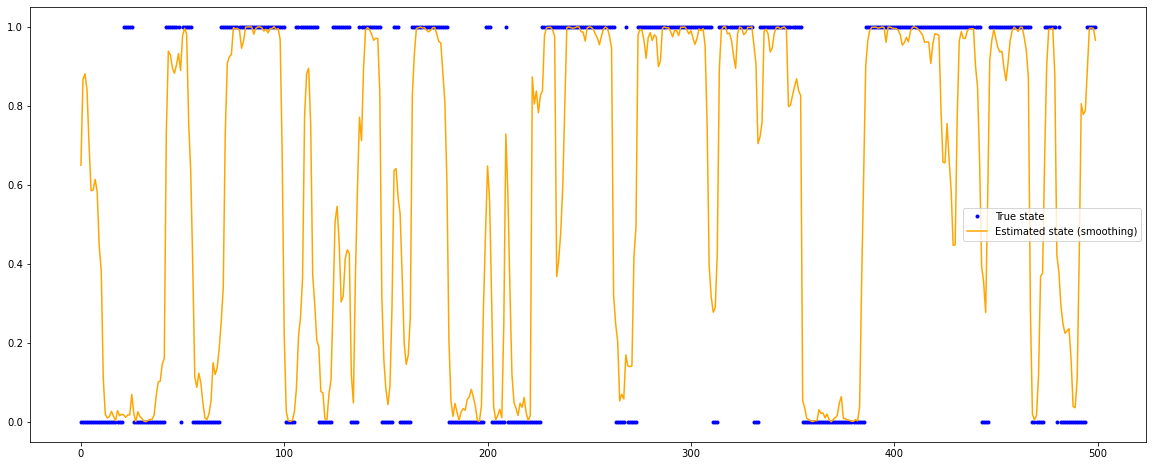

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(states)), states, '.', color = 'blue', label = 'True state')
plt.plot(range(len(states)), smooth_path[1, :], label = 'Estimated state (smoothing)', color = 'orange')
plt.legend()
plt.show()